In [ ]:
from beta_vs_radius_plot import CompactFiberSolver
import numpy as np

# 例: λ=1389 nm, 石英コア/空気クラッド
wavelength = 1389e-9
solver = CompactFiberSolver(wavelength, l=1)
lam_um = wavelength*1e6
n_silica = solver.sellmeier_silica(lam_um)
n_air = 1.0

# 与えたい beta を決める（有効屈折率 neff = beta/k0）
pitch = 750.41580341875147e-9

neff_target = (wavelength/2)/pitch    # 例
# print(neff_target)
beta_target = neff_target * solver.k0
d = solver.diameter_from_beta(beta_target, n_silica, n_air,
                              a_init_um=0.10, a_min_um=0.03, a_max_um=50.0,
                              grow=1.7, max_iter=25, eps=1e-12)
print(f"target neff = {neff_target:.9f} → diameter ≈ {d*1e6:.4f} µm")


ValueError: beta_target must be strictly between k0*n2 and k0*n1.

In [2]:
import inspect
print(inspect.signature(solver.diameter_from_beta))

(beta_target, n1, n2, a_init_um=0.1, grow=1.7, a_min_um=0.02, a_max_um=50.0, max_expand=60, max_iter=25, eps=1e-12)


In [61]:
pitches = np.loadtxt("pitch_summary.csv", delimiter=",", skiprows=1, usecols=8)
pitches_err = np.loadtxt("pitch_summary.csv", delimiter=",", skiprows=1, usecols=9)

In [62]:
print(pitches)
print(pitches_err)

[556.04995544 633.38741819 670.74554841 667.37984521 619.19436339
 537.45761015 505.41580342]
[0.03426512 0.0207091  0.0159341  0.02061627 0.10578453 0.11761779
 0.10916369]


In [63]:
diameter = []
diameter_plus = []
diameter_minus = []
for pitch, pitch_err in zip(pitches, pitches_err):
    pitch = pitch * 1e-9
    pitch_err = pitch_err * 1e-9 
    neff_target = (wavelength/2)/pitch
    beta_target = neff_target * solver.k0
    d = solver.diameter_from_beta(beta_target, n_silica, n_air,
                                  a_init_um=0.10, a_min_um=0.03, a_max_um=50.0,
                                  grow=1.7, max_iter=25, eps=1e-12)
    pitch_plus = pitch + pitch_err
    neff_target_plus = (wavelength/2)/pitch_plus
    beta_target_plus = neff_target_plus * solver.k0
    d_plus = solver.diameter_from_beta(beta_target_plus, n_silica, n_air,
                                       a_init_um=0.10, a_min_um=0.03, a_max_um=50.0,
                                       grow=1.7, max_iter=25, eps=1e-12)
    pitch_minus = pitch - pitch_err
    neff_target_minus = (wavelength/2)/pitch_minus
    beta_target_minus = neff_target_minus * solver.k0
    d_minus = solver.diameter_from_beta(beta_target_minus, n_silica, n_air,
                                        a_init_um=0.10, a_min_um=0.03, a_max_um=50.0,
                                        grow=1.7, max_iter=25, eps=1e-12)
    diameter.append(d*1e6)
    diameter_plus.append(d_plus*1e6)
    diameter_minus.append(d_minus*1e6)
    print(f"pitch = {pitch*1e9:.3f} ± {pitch_err*1e9:.3f} nm → diameter = {d*1e6:.3f} (+{(d_plus-d)*1e6:.3f}/-{(d-d_minus)*1e6:.3f}) µm")

pitch = 556.050 ± 0.034 nm → diameter = 1.129 (+0.000/-0.000) µm
pitch = 633.387 ± 0.021 nm → diameter = 0.743 (+0.000/-0.000) µm
pitch = 670.746 ± 0.016 nm → diameter = 0.561 (+0.000/-0.000) µm
pitch = 667.380 ± 0.021 nm → diameter = 0.561 (+0.000/-0.000) µm
pitch = 619.194 ± 0.106 nm → diameter = 0.743 (+0.000/-0.000) µm
pitch = 537.458 ± 0.118 nm → diameter = 1.299 (+0.000/-0.000) µm
pitch = 505.416 ± 0.109 nm → diameter = 1.493 (+0.000/-0.000) µm


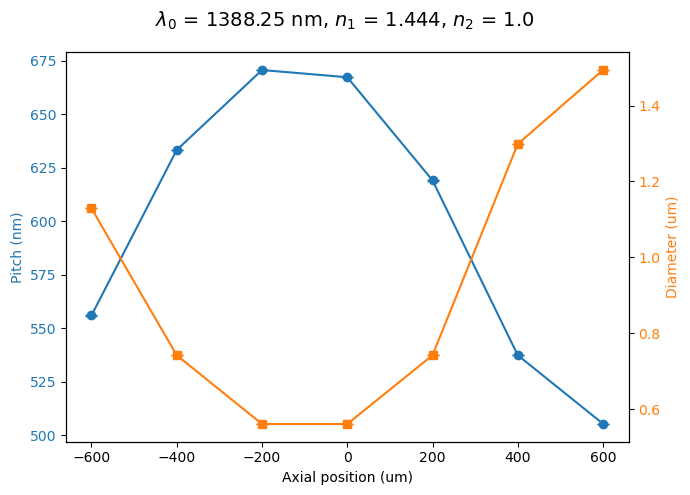

In [6]:
import matplotlib.pyplot as plt

# 例: 横軸を自分で指定 (位置[µm])
x_positions = np.array([-600, -400, -200, 0, 200, 400, 600])

# pitches, pitches_err は [nm]
# d_central_um, d_err_dn_um, d_err_up_um は [µm]（前の計算結果から）
pitches_nm = pitches        # [nm]
pitches_err_nm = pitches_err  # [nm]

fig, ax1 = plt.subplots(figsize=(7,5))

# --- 左軸: pitch ---
ax1.errorbar(x_positions, pitches_nm, yerr=pitches_err_nm,
             fmt='o-', capsize=4, label="Pitch")
ax1.set_xlabel("Axial position (um)")
ax1.set_ylabel("Pitch (nm)", color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# --- 右軸: diameter ---
ax2 = ax1.twinx()
ax2.errorbar(x_positions, diameter,
             yerr=[diameter_plus - np.array(diameter), np.array(diameter) - diameter_minus],
             fmt='s-', capsize=4, color='C1', label="Diameter")
ax2.set_ylabel("Diameter (um)", color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# タイトルやグリッド
fig.suptitle(r"$\lambda_0$ = 1388.25 nm, $n_1$ = 1.444, $n_2$ = 1.0", fontsize=14)
#ax1.grid(True, linestyle="--", alpha=0.6)

# 凡例を両軸の分をまとめて表示
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.show()

## SEM measurement result

SEM coating thickness : 17.445  +-  1.5269168281212966  nm


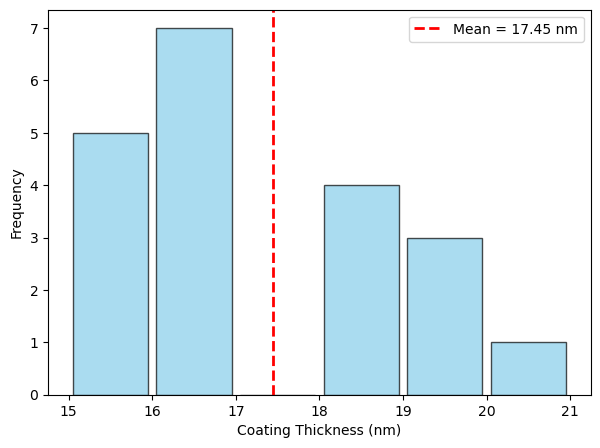

In [55]:
# coating thickness statistics 
import numpy as np 
import matplotlib.pyplot as plt

SEM_coating_1 = [16.9, 15.6, 18.3, 16.9]
SEM_coating_2 = [19.5, 18.3, 15.6, 16.9]
SEM_coating_3 = [16.9, 18.3, 16.9, 19.5]
SEM_coating_4 = [16.9, 15.6, 18.3, 20.9]
SEM_coating_5 = [16.9, 15.6, 15.6, 19.5]

SEM_coating_all = (
    SEM_coating_1 + SEM_coating_2 + SEM_coating_3 + SEM_coating_4 + SEM_coating_5
)

mean_coating = np.mean(SEM_coating_all)
sd_coating = np.std(SEM_coating_all)
print("SEM coating thickness :", mean_coating, " +- ", sd_coating, ' nm')

# --- Histogram settings ---
bins = np.arange(15, 22, 1)  # bins: 15-16, 16-17, 17-18, ...

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.hist(SEM_coating_all, bins=bins, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.9)

# Add vertical line for mean
plt.axvline(mean_coating, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_coating:.2f} nm")

# Add labels and title
plt.xlabel('Coating Thickness (nm)')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(bins)

# Show plot
plt.show()


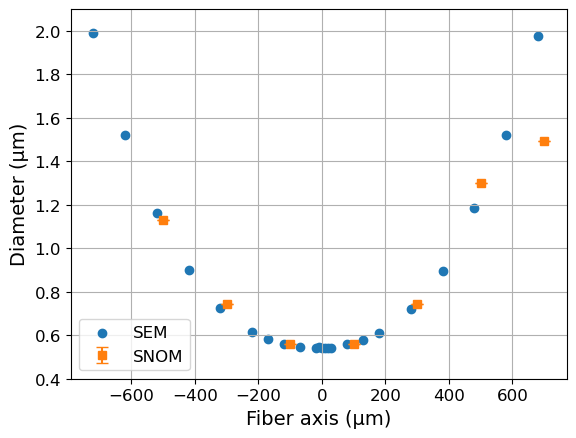

In [24]:
x = [0.0,  0.01, 0.02, 0.03, 0.04, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0.2, -0.2, 0.3, -0.3, 0.4, -0.4, 0.5, -0.5, 0.6, -0.6, 0.7, -0.7]
y = [555, 556, 552, 552, 552, 555, 559, 572, 572, 588, 592, 621, 625, 724, 731, 892, 896, 1170, 1150, 1490, 1490, 1930, 1940]


x = np.array(x)
y = np.array(y) - 17.445*2
# y = np.array(y)


x_centered = (x - 0.02)*1000   
y_centered = y/0.958/1000

x_SNOM = x_positions+100
y_SNOM = diameter


plt.scatter(x_centered, y_centered, label="SEM")
# plt.axhline(0.552/0.958, color='red', linestyle='--', linewidth=1.2, label='0.552 µm')
plt.errorbar(x_positions+100, diameter,
             yerr=[diameter_plus - np.array(diameter), np.array(diameter) - diameter_minus],
             fmt='s', capsize=4, color='C1', label="SNOM")
# plt.text(0.45, 0.552/0.958 + 0.05, "0.576 µm", color='red', fontsize=12,
#          bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))
plt.xlabel('Fiber axis (µm)', fontsize=14)
plt.ylabel('Diameter (µm)', fontsize=14)
plt.ylim(0.4, 2.1)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()




Residuals for SEM data: -0.07433326229685133
Residuals for each point: -3.3306690738754696e-16


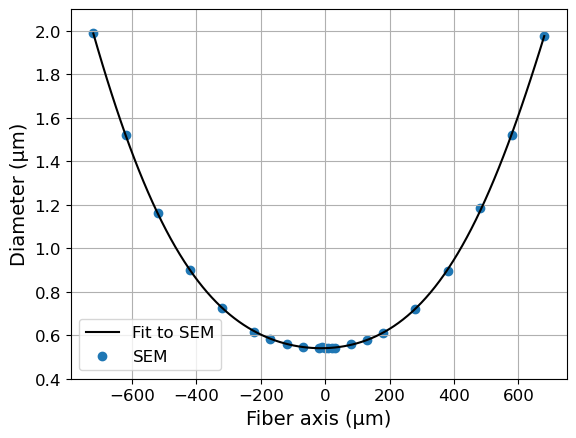

In [25]:
# Perform polynomial fitting
deg_f = 6
coefficients = np.polyfit(x_centered, y_centered, deg=deg_f)  
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the fit line
x_fit = np.linspace(min(x_centered), max(x_centered), 100)
y_fit = polynomial(x_fit)
# Calculate the residuals for each point
residuals = y_centered - polynomial(x_centered)
# Calculate the residuals between the fit and x_SNOM, y_SNOM
y_SNOM_fit = polynomial(x_SNOM)
residuals_SNOM = y_SNOM - y_SNOM_fit

# Print the residuals for SNOM data
print("Residuals for SEM data:", sum(residuals_SNOM)/deg_f)


# Print the residuals
print("Residuals for each point:", sum(residuals))

# Plot the fit line
plt.plot(x_fit, y_fit, color='k', linestyle='-', label='Fit to SEM')
plt.scatter(x_centered, y_centered, label="SEM")
# plt.errorbar(x_SNOM, y_SNOM,
#              yerr=[diameter_plus - np.array(diameter), np.array(diameter) - diameter_minus],
#              fmt='s', capsize=4, color='C1', label="SNOM")
plt.xlabel('Fiber axis (µm)', fontsize=14)
plt.ylabel('Diameter (µm)', fontsize=14)
plt.ylim(0.4, 2.1)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


C:\Users\ItoiJoe\AppData\Local\Temp\ipykernel_45180\772588161.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


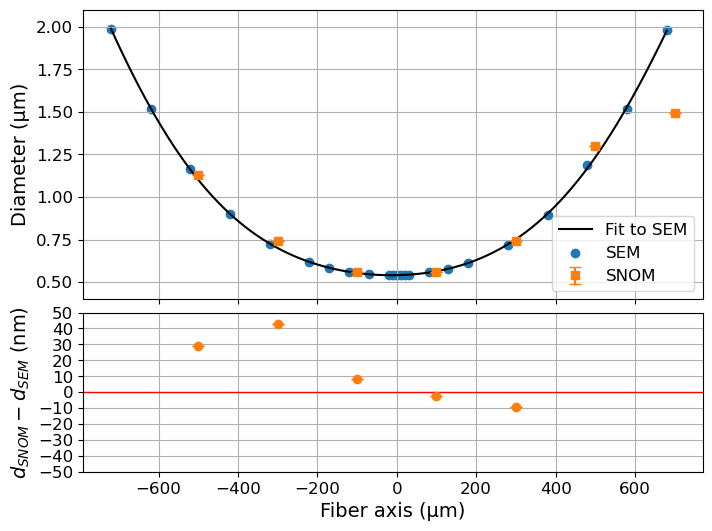

In [26]:
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(8, 6),
    sharex=True, gridspec_kw={'height_ratios': [2, 1.1], 'hspace': 0.06}
)
# --- Top plot (same as your original) ---
ax_top.plot(x_fit, y_fit, color='k', linestyle='-', label='Fit to SEM')
ax_top.scatter(x_centered, y_centered, label="SEM")
ax_top.errorbar(x_SNOM, y_SNOM,
                yerr=[diameter_plus - np.array(diameter),
                      np.array(diameter) - diameter_minus],
                fmt='s', capsize=4, color='C1', label="SNOM")
ax_top.set_ylabel('Diameter (µm)', fontsize=14)
ax_top.set_ylim(0.4, 2.1)
ax_top.tick_params(axis='both', which='major', labelsize=12)
ax_top.legend(fontsize=12)
ax_top.grid(True)

# --- Bottom plot (residuals vs SNOM) ---
ax_bot.axhline(0, color='r', linewidth=1.0)
ax_bot.errorbar(x_SNOM, residuals_SNOM*1000,
                yerr=[diameter_plus - np.array(diameter),
                      np.array(diameter) - diameter_minus],
                fmt='o', capsize=4, color='C1')
ax_bot.set_xlabel('Fiber axis (µm)', fontsize=14)
ax_bot.set_ylabel(r'$d_{\text{SNOM}} - d_{\text{SEM}}$ (nm)', fontsize=14)
ax_bot.set_ylabel('$d_{SNOM} - d_{SEM}$ (nm)', fontsize=14)
# ax_bot.set_ylim(-0.08*1000, 0.08*1000)
ax_bot.set_ylim(-0.05*1000, 0.05*1000)
ax_bot.yaxis.set_major_locator(plt.MultipleLocator(0.010*1000))

ax_bot.tick_params(axis='both', which='major', labelsize=12)
ax_bot.grid(True)

plt.tight_layout()
plt.show()